# To pinpoint specific geographic locations and temporal patterns where accidents occur most frequently, enabling targeted measures to enhance road safety.

## Setup and Data Loading

In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pyspark in c:\users\kusum\appdata\local\programs\python\python311\lib\site-packages (3.5.0)




[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("objective_1").getOrCreate()

In [5]:
df = spark.read.csv("Road.csv", inferSchema=True, header=True)

In [6]:
print("Rows: ", df.count())
print("Columns: ", len(df.columns))

Rows:  12316
Columns:  32


In [7]:
df.printSchema()

root
 |-- Time: timestamp (nullable = true)
 |-- Day_of_week: string (nullable = true)
 |-- Age_band_of_driver: string (nullable = true)
 |-- Sex_of_driver: string (nullable = true)
 |-- Educational_level: string (nullable = true)
 |-- Vehicle_driver_relation: string (nullable = true)
 |-- Driving_experience: string (nullable = true)
 |-- Type_of_vehicle: string (nullable = true)
 |-- Owner_of_vehicle: string (nullable = true)
 |-- Service_year_of_vehicle: string (nullable = true)
 |-- Defect_of_vehicle: string (nullable = true)
 |-- Area_accident_occured: string (nullable = true)
 |-- Lanes_or_Medians: string (nullable = true)
 |-- Road_allignment: string (nullable = true)
 |-- Types_of_Junction: string (nullable = true)
 |-- Road_surface_type: string (nullable = true)
 |-- Road_surface_conditions: string (nullable = true)
 |-- Light_conditions: string (nullable = true)
 |-- Weather_conditions: string (nullable = true)
 |-- Type_of_collision: string (nullable = true)
 |-- Number_of_ve

In [8]:
df.groupBy("Accident_severity").count().show()

+-----------------+-----+
|Accident_severity|count|
+-----------------+-----+
|   Serious Injury| 1743|
|    Slight Injury|10415|
|     Fatal injury|  158|
+-----------------+-----+



In [10]:
df.groupBy("Area_accident_occured").count().show(truncate=False)

+-------------------------------+-----+
|Area_accident_occured          |count|
+-------------------------------+-----+
| Hospital areas                |121  |
|NULL                           |239  |
|Unknown                        |22   |
|Recreational areas             |1    |
|Other                          |3819 |
|Rural village areas            |44   |
|Office areas                   |3451 |
|School areas                   |415  |
|Rural village areasOffice areas|20   |
|  Recreational areas           |327  |
|  Market areas                 |63   |
|Residential areas              |2060 |
| Church areas                  |1060 |
| Outside rural areas           |218  |
| Industrial areas              |456  |
+-------------------------------+-----+



## Choosing Columns

- 'Day_of_the_week', 'Weather_conditions_Encoded', 'Light_conditions_Encoded', 'Road_surface_conditions_Encoded',
    'Type_of_vehicle_Encoded', 'Area_accident_occured_Encoded', 'Day_of_week_numeric', 'Hour'

In [13]:
from pyspark.sql.functions import hour, minute

df = df.withColumn('Hour', hour(df['Time']))
df = df.withColumn('Minute', minute(df['Time']))

df_filter = df.filter(df['Day_of_week'].isNotNull())
df_filter = df_filter.filter(df_filter['Hour'].isNotNull())

In [105]:
selected_columns = ['Accident_severity','Day_of_week', 'Weather_conditions', 'Light_conditions', 'Road_surface_conditions', 'Type_of_vehicle', 'Area_accident_occured', 'Hour', 'Age_band_of_driver', 'Types_of_Junction']
df = df_filter.select(selected_columns)


In [106]:
df = df.na.drop() # drop the Nulls

In [107]:
df.describe().show()

+-------+-----------------+-----------+------------------+--------------------+-----------------------+---------------+---------------------+------------------+------------------+-----------------+
|summary|Accident_severity|Day_of_week|Weather_conditions|    Light_conditions|Road_surface_conditions|Type_of_vehicle|Area_accident_occured|              Hour|Age_band_of_driver|Types_of_Junction|
+-------+-----------------+-----------+------------------+--------------------+-----------------------+---------------+---------------------+------------------+------------------+-----------------+
|  count|            10361|      10361|             10361|               10361|                  10361|          10361|                10361|             10361|             10361|            10361|
|   mean|             NULL|       NULL|              NULL|                NULL|                   NULL|           NULL|                 NULL|13.808705723385774|              NULL|             NULL|
| stddev| 

In [108]:
from pyspark.sql.functions import when

In [109]:
df_severity_as_integer = df.withColumn(
    'accident_severity_integer',
    when(df['Accident_severity'] == 'Slight Injury', 1.0)
    .when(df['Accident_severity'] == 'Serious Injury', 2.0)
    .when(df['Accident_severity'] == 'Fatal injury', 3.0)
)

In [110]:
df_severity_as_integer.select("accident_severity_integer").describe().show()

+-------+-------------------------+
|summary|accident_severity_integer|
+-------+-------------------------+
|  count|                    10361|
|   mean|        1.166682752630055|
| stddev|      0.40474250432554215|
|    min|                      1.0|
|    max|                      3.0|
+-------+-------------------------+



### Converting strings into numerical format (using StringIndexer and OneHotEncoder).

In [111]:
df.printSchema()

root
 |-- Accident_severity: string (nullable = true)
 |-- Day_of_week: string (nullable = true)
 |-- Weather_conditions: string (nullable = true)
 |-- Light_conditions: string (nullable = true)
 |-- Road_surface_conditions: string (nullable = true)
 |-- Type_of_vehicle: string (nullable = true)
 |-- Area_accident_occured: string (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Age_band_of_driver: string (nullable = true)
 |-- Types_of_Junction: string (nullable = true)



In [113]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

indexer = StringIndexer(inputCol="Day_of_week", outputCol="Day_of_week"+"_index")
indexed = indexer.fit(df_severity_as_integer).transform(df_severity_as_integer)

indexer = StringIndexer(inputCol="Weather_conditions", outputCol="Weather_conditions"+"_index")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="Light_conditions", outputCol="Light_conditions"+"_index")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="Road_surface_conditions", outputCol="Road_surface_conditions"+"_index")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="Type_of_vehicle", outputCol="Type_of_vehicle"+"_index")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="Area_accident_occured", outputCol="Area_accident_occured"+"_index")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="Age_band_of_driver", outputCol="Age_band_of_driver"+"_index")
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol="Types_of_Junction", outputCol="Types_of_Junction"+"_index")
indexed = indexer.fit(indexed).transform(indexed)

In [114]:
indexed.show()

+-----------------+-----------+------------------+--------------------+-----------------------+--------------------+---------------------+----+------------------+-----------------+-------------------------+-----------------+------------------------+----------------------+-----------------------------+---------------------+---------------------------+------------------------+-----------------------+
|Accident_severity|Day_of_week|Weather_conditions|    Light_conditions|Road_surface_conditions|     Type_of_vehicle|Area_accident_occured|Hour|Age_band_of_driver|Types_of_Junction|accident_severity_integer|Day_of_week_index|Weather_conditions_index|Light_conditions_index|Road_surface_conditions_index|Type_of_vehicle_index|Area_accident_occured_index|Age_band_of_driver_index|Types_of_Junction_index|
+-----------------+-----------+------------------+--------------------+-----------------------+--------------------+---------------------+----+------------------+-----------------+----------------

In [115]:
indexed.printSchema()

root
 |-- Accident_severity: string (nullable = true)
 |-- Day_of_week: string (nullable = true)
 |-- Weather_conditions: string (nullable = true)
 |-- Light_conditions: string (nullable = true)
 |-- Road_surface_conditions: string (nullable = true)
 |-- Type_of_vehicle: string (nullable = true)
 |-- Area_accident_occured: string (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Age_band_of_driver: string (nullable = true)
 |-- Types_of_Junction: string (nullable = true)
 |-- accident_severity_integer: double (nullable = true)
 |-- Day_of_week_index: double (nullable = false)
 |-- Weather_conditions_index: double (nullable = false)
 |-- Light_conditions_index: double (nullable = false)
 |-- Road_surface_conditions_index: double (nullable = false)
 |-- Type_of_vehicle_index: double (nullable = false)
 |-- Area_accident_occured_index: double (nullable = false)
 |-- Age_band_of_driver_index: double (nullable = false)
 |-- Types_of_Junction_index: double (nullable = false)



In [152]:
assembler = VectorAssembler(inputCols=["Hour", "Day_of_week_index",
                                       "Weather_conditions_index", "Light_conditions_index",
                                       "Road_surface_conditions_index", "Type_of_vehicle_index",
                                       "Area_accident_occured_index", "Age_band_of_driver_index"], outputCol="features")

In [153]:
assembler

VectorAssembler_4506f9497e6d

In [154]:
output = assembler.transform(indexed)
output.show()

+-----------------+-----------+------------------+--------------------+-----------------------+--------------------+---------------------+----+------------------+-----------------+-------------------------+-----------------+------------------------+----------------------+-----------------------------+---------------------+---------------------------+------------------------+-----------------------+--------------------+
|Accident_severity|Day_of_week|Weather_conditions|    Light_conditions|Road_surface_conditions|     Type_of_vehicle|Area_accident_occured|Hour|Age_band_of_driver|Types_of_Junction|accident_severity_integer|Day_of_week_index|Weather_conditions_index|Light_conditions_index|Road_surface_conditions_index|Type_of_vehicle_index|Area_accident_occured_index|Age_band_of_driver_index|Types_of_Junction_index|            features|
+-----------------+-----------+------------------+--------------------+-----------------------+--------------------+---------------------+----+-----------

In [155]:
output.select("features", "Accident_severity").show(truncate=False)

+----------------------------------+-----------------+
|features                          |Accident_severity|
+----------------------------------+-----------------+
|(8,[0,1,6],[17.0,5.0,2.0])        |Slight Injury    |
|[17.0,5.0,0.0,0.0,0.0,8.0,1.0,1.0]|Slight Injury    |
|(8,[0,1,5,6],[17.0,5.0,1.0,6.0])  |Serious Injury   |
|[1.0,6.0,0.0,1.0,0.0,8.0,1.0,0.0] |Slight Injury    |
|(8,[0,1,6],[17.0,2.0,2.0])        |Slight Injury    |
|(8,[0,6],[17.0,2.0])              |Slight Injury    |
|(8,[0,5,6],[17.0,1.0,4.0])        |Slight Injury    |
|(8,[0,6],[17.0,2.0])              |Serious Injury   |
|(8,[0,1,5,6],[14.0,4.0,7.0,2.0])  |Serious Injury   |
|(8,[0,1,6,7],[14.0,4.0,1.0,1.0])  |Serious Injury   |
|(8,[0,1,5,6],[17.0,1.0,8.0,1.0])  |Slight Injury    |
|[17.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0]|Slight Injury    |
|(8,[0,1,6,7],[17.0,1.0,1.0,1.0])  |Serious Injury   |
|[22.0,5.0,1.0,1.0,1.0,6.0,1.0,0.0]|Serious Injury   |
|[22.0,5.0,1.0,1.0,1.0,7.0,1.0,0.0]|Slight Injury    |
|[22.0,5.0

In [156]:
model_df = output.select("features", "accident_severity_integer")
model_df.describe().show()

+-------+-------------------------+
|summary|accident_severity_integer|
+-------+-------------------------+
|  count|                    10361|
|   mean|        1.166682752630055|
| stddev|      0.40474250432554215|
|    min|                      1.0|
|    max|                      3.0|
+-------+-------------------------+



In [157]:
unique_values_count = model_df.groupBy("accident_severity_integer").count()
unique_values_count.show()

+-------------------------+-----+
|accident_severity_integer|count|
+-------------------------+-----+
|                      1.0| 8763|
|                      3.0|  129|
|                      2.0| 1469|
+-------------------------+-----+



In [158]:
model_df.show()


+--------------------+-------------------------+
|            features|accident_severity_integer|
+--------------------+-------------------------+
|(8,[0,1,6],[17.0,...|                      1.0|
|[17.0,5.0,0.0,0.0...|                      1.0|
|(8,[0,1,5,6],[17....|                      2.0|
|[1.0,6.0,0.0,1.0,...|                      1.0|
|(8,[0,1,6],[17.0,...|                      1.0|
|(8,[0,6],[17.0,2.0])|                      1.0|
|(8,[0,5,6],[17.0,...|                      1.0|
|(8,[0,6],[17.0,2.0])|                      2.0|
|(8,[0,1,5,6],[14....|                      2.0|
|(8,[0,1,6,7],[14....|                      2.0|
|(8,[0,1,5,6],[17....|                      1.0|
|[17.0,1.0,0.0,0.0...|                      1.0|
|(8,[0,1,6,7],[17....|                      2.0|
|[22.0,5.0,1.0,1.0...|                      2.0|
|[22.0,5.0,1.0,1.0...|                      1.0|
|[22.0,5.0,1.0,1.0...|                      2.0|
|(8,[0,1,5,6],[8.0...|                      2.0|
|(8,[0,1,5,7],[8.0..

In [159]:
training_df, test_df = model_df.randomSplit([0.7, 0.3]) #seed = 123

In [160]:
test_df.groupBy("accident_severity_integer").count().show()
training_df.groupBy("accident_severity_integer").count().show()


+-------------------------+-----+
|accident_severity_integer|count|
+-------------------------+-----+
|                      1.0| 2629|
|                      3.0|   41|
|                      2.0|  431|
+-------------------------+-----+

+-------------------------+-----+
|accident_severity_integer|count|
+-------------------------+-----+
|                      1.0| 6134|
|                      3.0|   88|
|                      2.0| 1038|
+-------------------------+-----+



In [161]:
print("Training dataset samples: ", training_df.count())
print("Test dataset samples: ", test_df.count())

Training dataset samples:  7260
Test dataset samples:  3101


In [162]:
from pyspark.ml.classification import LogisticRegression

In [163]:
log_reg = LogisticRegression(labelCol="accident_severity_integer", family="multinomial").fit(training_df)

In [164]:
log_reg

LogisticRegressionModel: uid=LogisticRegression_dff1676e4748, numClasses=4, numFeatures=8

In [165]:
training_results = log_reg.evaluate(training_df).predictions

In [166]:
training_results.describe().show()

+-------+-------------------------+----------+
|summary|accident_severity_integer|prediction|
+-------+-------------------------+----------+
|  count|                     7260|      7260|
|   mean|       1.1672176308539945|       1.0|
| stddev|      0.40437710439641467|       0.0|
|    min|                      1.0|       1.0|
|    max|                      3.0|       1.0|
+-------+-------------------------+----------+



In [167]:
results = log_reg.evaluate(test_df).predictions

In [168]:
results.describe().show()

+-------+-------------------------+--------------------+
|summary|accident_severity_integer|          prediction|
+-------+-------------------------+--------------------+
|  count|                     3101|                3101|
|   mean|       1.1654305062882941|                 1.0|
| stddev|      0.40565922066955157|1.903746599594966...|
|    min|                      1.0|                 1.0|
|    max|                      3.0|                 1.0|
+-------+-------------------------+--------------------+



In [169]:
results.select(["accident_severity_integer", "prediction"]).show(10)

+-------------------------+----------+
|accident_severity_integer|prediction|
+-------------------------+----------+
|                      1.0|       1.0|
|                      1.0|       1.0|
|                      1.0|       1.0|
|                      1.0|       1.0|
|                      1.0|       1.0|
|                      1.0|       1.0|
|                      1.0|       1.0|
|                      1.0|       1.0|
|                      1.0|       1.0|
|                      1.0|       1.0|
+-------------------------+----------+
only showing top 10 rows



In [170]:
results.describe().show()

+-------+-------------------------+--------------------+
|summary|accident_severity_integer|          prediction|
+-------+-------------------------+--------------------+
|  count|                     3101|                3101|
|   mean|       1.1654305062882941|                 1.0|
| stddev|      0.40565922066955157|1.903746599594966...|
|    min|                      1.0|                 1.0|
|    max|                      3.0|                 1.0|
+-------+-------------------------+--------------------+



In [171]:
# For class 1.0
tp_1 = results[(results.accident_severity_integer == 1.0) & (results.prediction == 1.0)].count()
tn_1 = results[(results.accident_severity_integer != 1.0) & (results.prediction != 1.0)].count()
fp_1 = results[(results.accident_severity_integer != 1.0) & (results.prediction == 1.0)].count()
fn_1 = results[(results.accident_severity_integer == 1.0) & (results.prediction != 1.0)].count()

# For class 2.0
tp_2 = results[(results.accident_severity_integer == 2.0) & (results.prediction == 2.0)].count()
tn_2 = results[(results.accident_severity_integer != 2.0) & (results.prediction != 2.0)].count()
fp_2 = results[(results.accident_severity_integer != 2.0) & (results.prediction == 2.0)].count()
fn_2 = results[(results.accident_severity_integer == 2.0) & (results.prediction != 2.0)].count()

# For class 0.0
tp_0 = results[(results.accident_severity_integer == 0.0) & (results.prediction == 0.0)].count()
tn_0 = results[(results.accident_severity_integer != 0.0) & (results.prediction != 0.0)].count()
fp_0 = results[(results.accident_severity_integer != 0.0) & (results.prediction == 0.0)].count()
fn_0 = results[(results.accident_severity_integer == 0.0) & (results.prediction != 0.0)].count()


In [172]:
total_tp = tp_1 + tp_2 + tp_0
total_fp = fp_1 + fp_2 + fp_0
total_fn = fn_1 + fn_2 + fn_0
total_tn = tn_0 + tn_1 + tn_2

In [173]:
total_observations = results.count()
accuracy = float(total_tp) / total_observations  # Overall accuracy

print("Accuracy: ", accuracy) #0.847597836461979 

Accuracy:  0.8477910351499516


In [138]:
recall_micro = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

recall = float(total_tn) / (total_tp+total_tn)
print("recall: ", recall)

recall:  0.6867356538099718


In [151]:
precision = float(total_tp) / (total_tp + total_fp) if (total_tp + total_fp) != 0 else 0

f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("F-score: ", f_score)

F-score:  0.7587342101063903


c:\Users\kusum\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


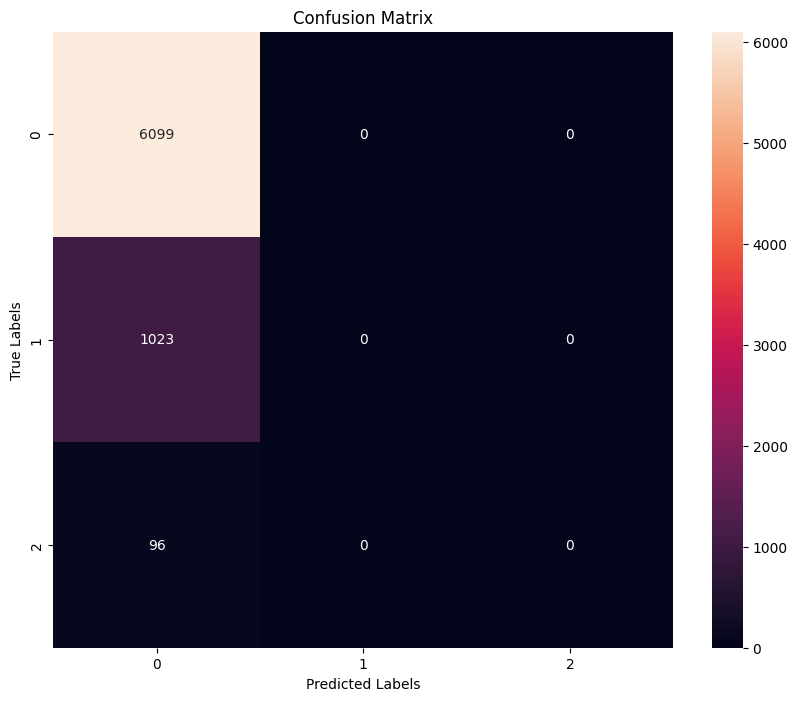

In [139]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert predictions to RDD
predictionAndLabels = training_results.select("prediction", "accident_severity_integer").rdd

# Step 2: Initialize MulticlassMetrics with the RDD
metrics = MulticlassMetrics(predictionAndLabels)

# Step 3: Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [140]:
# Decision Tree

In [141]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [142]:
dt_df_classifier = DecisionTreeClassifier(labelCol="accident_severity_integer").fit(training_df)

In [143]:
dt_df_predictions = dt_df_classifier.transform(test_df)

In [144]:
dt_df_predictions.show()

+--------------------+-------------------------+--------------------+--------------------+----------+
|            features|accident_severity_integer|       rawPrediction|         probability|prediction|
+--------------------+-------------------------+--------------------+--------------------+----------+
|      (9,[0],[10.0])|                      1.0|[0.0,736.0,153.0,...|[0.0,0.8177777777...|       1.0|
|      (9,[0],[13.0])|                      1.0|[0.0,736.0,153.0,...|[0.0,0.8177777777...|       1.0|
|      (9,[0],[14.0])|                      1.0|[0.0,736.0,153.0,...|[0.0,0.8177777777...|       1.0|
| (9,[0,1],[7.0,1.0])|                      2.0|[0.0,1809.0,261.0...|[0.0,0.8606089438...|       1.0|
| (9,[0,1],[7.0,2.0])|                      1.0|[0.0,1809.0,261.0...|[0.0,0.8606089438...|       1.0|
|(9,[0,1],[10.0,3.0])|                      1.0|[0.0,1809.0,261.0...|[0.0,0.8606089438...|       1.0|
|(9,[0,1],[13.0,5.0])|                      1.0|[0.0,1809.0,261.0...|[0.0,0.860608

In [145]:
dt_df_accuracy = MulticlassClassificationEvaluator(labelCol="accident_severity_integer",
                                                   metricName="accuracy").evaluate(dt_df_predictions)

In [146]:
print("Accuracy: ", dt_df_accuracy)

Accuracy:  0.8466433343938912


In [147]:
dt_df_percision = MulticlassClassificationEvaluator(labelCol="accident_severity_integer",
                                                   metricName="weightedPrecision").evaluate(dt_df_predictions)

In [148]:
print("Percision: ", dt_df_percision)

Percision:  0.759217925159246


In [149]:
df.columns

['Accident_severity',
 'Day_of_week',
 'Weather_conditions',
 'Light_conditions',
 'Road_surface_conditions',
 'Type_of_vehicle',
 'Area_accident_occured',
 'Hour',
 'Age_band_of_driver',
 'Types_of_Junction']

In [150]:
dt_df_classifier.featureImportances

SparseVector(9, {0: 0.1249, 1: 0.0521, 3: 0.1338, 5: 0.157, 6: 0.1455, 7: 0.2476, 8: 0.139})